In [2]:
import sys 
import os
import cobra
import cplex 
import libsbml
import copy
from pathlib import Path
import memote
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import path 
import pandas as pd
import numpy as np
from scipy.stats import zscore
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
import multiprocessing
from itertools import combinations, product
from multiprocessing import Pool
from sklearn.decomposition import PCA
import mplcursors


from sklearn.linear_model  import LinearRegression

#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src/")

import model_initialize as mi
import model_manipulation as mm


#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'gurobi'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


#Add trans reactions to trans_model
mi.add_trans_reactions(trans_model)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-09


Pipeline breakdown:

Load CSVs to a memory saving format first

1.
Run convergence statistics on each and generate plots to assess total convergence stats for each CSV. These will include tests such as the Geweke statistic. 
Afterwards get only the flux names of those reactions that have converged
Run pairwise Kruskal-wallis tests per CSV using the above list of converged reactions
Identify each reaction with significant and non-significant distributions each

Generate histograms/probability densities for relevant reactions with significantly different distributions with WT and Trans models

2. Flux coupling analysis
Check which fluxes are coupled with each otehr and identify which fluxes are then related to each other, particularly Carbon Fixation reactions in the BS cell such as Rubisco and the DM_Phloem reactions. 


In [4]:
'''This code block contains functions that we need to use to analyze our flux sampling experiment. 
These include tests to check for convergence, for autocorrelation, as well as for pairwise comparisons of fluxes between
parametization regimens (WT, TR, as well as 3 light conditions) and a script to determine whether fluxes are
coupled with each other. Lastly, I also tried PCA to determine which reactions contribute most to the variance of each null space distribution per
sampling run.
'''

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name


def load_csv_and_cleanup(filename, tol=1e-7):
    # Load the CSV file
    df = pd.read_csv(filename)

    # Remove columns with a mean below tolerance
    mean_values = df.mean()
    columns_to_remove = mean_values[abs(mean_values) < tol].index
    df = df.drop(columns=columns_to_remove)

    # Fix the indices
    df.reset_index(drop=True, inplace=True)
    print(df.shape)

    return df    

    


def compare_pair(reaction, df1, df2, significance_threshold):
    """
    Compare the flux distributions of a pair of columns from two dataframes using the Kruskal-Wallis test.

    :param pair: Tuple containing the pair of column names.
    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test.
    :return: The pair and the result of the Kruskal-Wallis test.
    """
    sample1 = df1[reaction]
    sample2 = df2[reaction]
    H, pval = kruskal(sample1, sample2)
    return pval 

def compare_flux_distributions(df1, df2, significance_threshold=0.05):
    """
    Compare the flux distributions of each pair of columns from two dataframes using the Kruskal-Wallis test.

    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test (default: 0.05).
    :return: A list of pairs with significantly different distributions.
    """
    common_columns = set(df1.columns) & set(df2.columns)
    
    pool = multiprocessing.Pool()
    sig_results = []
    non_sig_results = []
    
    for rxn in common_columns:
        kw_pval = compare_pair(rxn, df1, df2, significance_threshold) #This does the Kruskal-Wallis part
        if kw_pval < significance_threshold:
            sig_results.append(rxn)
        else:
            non_sig_results.append(rxn)
            
    #Sort the outputs before returning
    sig_results.sort()
    non_sig_results.sort()
            
    
    return sig_results, non_sig_results



#The script above is used for flux coupling using the opened CSV file as input and outputs 3 lists:
#positively correlated, neg. correlated and uncoupled reactions


#This is for visualization
def generate_histograms(dataframe1, dataframe2, column_name):
    # Create subplots for two histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Histogram for dataframe1
    axes[0].hist(dataframe1[column_name], bins=10, color='skyblue')
    axes[0].set_title(f'Histogram of {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Frequency')

    # Histogram for dataframe2
    axes[1].hist(dataframe2[column_name], bins=10, color='lightgreen')
    axes[1].set_title(f'Histogram of {column_name}')
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel('Frequency')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the histograms
    plt.show()

    
def generate_stacked_histogram(dataframes, column_name,histtype='bar'):
    fig = plt.figure()
    
    # Concatenate the column data from all dataframes into a single series
    
    df_name = list()
    
    
    for dfs in dataframes:
    # Create the stacked histogram
        if column_name in dfs.columns:

            plt.hist(dfs[column_name], bins=33, alpha=0.45, stacked=True, density=False,histtype=histtype)
            df_name.append(get_df_name(dfs))
        else:
            pass
    
    
    
    
    # Set plot title and labels
    plt.title(f"Stacked Histogram for Column: {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Counts")
    plt.legend(df_name)
 
    
    plt.figure().set_figheight(1)
    
    return fig

def plot_scatter_regression(df, column_x, column_y):
    """
    Generates a scatterplot and a linear regression line between two columns in a dataframe.

    Parameters:
        - df (pandas.DataFrame): The input dataframe.
        - column_x (str): The column name for the X-axis.
        - column_y (str): The column name for the Y-axis.
    """

    # Extract X and Y values from the dataframe
    X = df[column_x].values.reshape(-1, 1)
    Y = df[column_y].values

    # Fit linear regression model
    regression = LinearRegression()
    regression.fit(X, Y)

    # Predict Y values based on the regression line
    Y_pred = regression.predict(X)

    # Plot the scatterplot and regression line
    plt.scatter(X, Y, color='blue', label='Actual')
    plt.plot(X, Y_pred, color='red', label='Regression Line')
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.title('Scatterplot with Linear Regression Line')
    plt.legend()
    plt.show()


    
    
#These functions are for generating PCA plots and other corollary analyses

def merge_dataframes(dataframes, names):
    merged_df = pd.DataFrame()
    
    for i, df in enumerate(dataframes):
        # Get the corresponding name from the names list
        df_name = names[i]
        
        # Add a new column with the dataframe name
        df['sample'] = df_name
        
        # Merge dataframes
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # Remove NAs
    merged_df = merged_df.fillna(1e-7)
    
    return merged_df

def generate_pca_plot(dataframe):
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns
    X = dataframe[numeric_columns].values

    pca = PCA(n_components=3)

    components = pca.fit_transform(X)

    # Extract dataframe names
    dataframe_names = dataframe['sample'].unique()

    # Generate plot with different colors for each dataframe
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']  # Add more colors if needed

    #Generate figure and subplot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, name in enumerate(dataframe_names):
        indices = dataframe['sample'] == name
        ax.scatter(components[indices, 0], components[indices, 1], label=name, c=colors[i])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    
    mplcursors.cursor(hover=True)
    plt.show()
 
    #export PCA to determine component variance
    
    pca_fit = pca.fit(X)
    
    return pca_fit

def select_significant_features(pca, feature_names, top_n):
    loadings = pca.components_
    abs_loadings = np.abs(loadings)
    feature_contribution = np.sum(abs_loadings, axis=0)
    sorted_features = feature_names[np.argsort(feature_contribution)[::-1]]
    selected_features = sorted_features[:top_n]
    return selected_features

def plot_selected_features_heatmap(pca, feature_names, selected_features):
    loadings = pca.components_
    selected_indices = [np.where(feature_names == feature)[0][0] for feature in selected_features]
    selected_loadings = loadings[:, selected_indices]

    plt.figure(figsize=(10, 6))
    sns.heatmap(selected_loadings, cmap='coolwarm', annot=False, xticklabels=selected_features)
    plt.xlabel('Selected Features')
    plt.ylabel('Principal Components')
    plt.title('Loadings Heatmap of Selected Features')
    plt.show()


    
def visualize_correlation_matrix(df, sort_by=None, ascending=False):
    """
    Calculates and visualizes the correlation matrix based on flux measurements in a dataframe.

    Parameters:
        - df (pandas.DataFrame): The input dataframe containing flux measurements.
        - sort_by (str or None): Column name to sort the correlation matrix by. Default is None.
        - ascending (bool): Whether to sort in ascending order. Default is False.
    """

    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Sort the correlation matrix if sort_by is specified
    if sort_by is not None:
        correlation_matrix = correlation_matrix.sort_values(by=sort_by, ascending=ascending)

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

    # Set plot title
    plt.title('Correlation Matrix')

    # Display the heatmap
    plt.show()

def filter_correlation_pairs(correlation_matrix, threshold, filter_elements):
    """
    Filters out specific pairs in the correlation matrix based on a specified absolute value threshold,
    removes pairs that share columns, removes symmetrical results, and returns the rows where the filter elements are found in either of the two variable columns.

    Parameters:
        - correlation_matrix (pandas.DataFrame): The correlation matrix.
        - threshold (float): The absolute value threshold to filter the correlation coefficients.
        - filter_elements (list): The elements to filter out from the correlation matrix.

    Returns:
        - filtered_pairs (pandas.DataFrame): The table showing the filtered pairs and their correlation coefficients,
                                             where the filter elements are found in either of the two variable columns,
                                             with symmetrical results removed.
    """
    # Filter out pairs based on the threshold
    filtered_pairs = correlation_matrix.unstack().reset_index()
    filtered_pairs = filtered_pairs.rename(columns={'level_0': 'Variable A', 'level_1': 'Variable B', 0: 'Correlation'})
    filtered_pairs = filtered_pairs[filtered_pairs['Correlation'].abs() >= threshold]

    # Remove pairs that share columns
    filtered_pairs = filtered_pairs[~(filtered_pairs['Variable A'] == filtered_pairs['Variable B'])]

    # Remove symmetrical results
    filtered_pairs = filtered_pairs[filtered_pairs['Variable A'] < filtered_pairs['Variable B']]

    # Filter rows where the filter elements are found in either of the two variable columns
    filtered_pairs = filtered_pairs[(filtered_pairs['Variable A'].isin(filter_elements)) | (filtered_pairs['Variable B'].isin(filter_elements))]
    
    # Sort the filtered pairs by correlation coefficient in descending order
    filtered_pairs = filtered_pairs.sort_values('Correlation', ascending=False)
    
    filtered_pairs = filtered_pairs.reset_index()
    

    return filtered_pairs

def check_column_exists(dataframes, column_name):
    for df in dataframes:
        if column_name in df.columns:
            return True
    return False



In [5]:
#Test the script on one CSV

wt_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_250_Relaxed_loopless_FVA_100kT.csv', )
wt_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_750_Relaxed_loopless_FVA_100kT_reran.csv')
wt_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_WT_1500_Relaxed_loopless_FVA_100kT_reran.csv')
tr_250 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_250_Relaxed_loopless_FVA_100kT.csv')
tr_750 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_750_Relaxed_loopless_FVA_100kT.csv')
tr_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/flux_sample_TR_1500_Relaxed_loopless_FVA_100kT.csv')




    

df_list = [wt_250, wt_750, wt_1500, tr_250, tr_750, tr_1500]
names = ['wt_250', 'wt_750', 'wt_1500', 'tr_250', 'tr_750', 'tr_1500']
wt_list = [wt_250, wt_750, wt_1500]
tr_list = [tr_250, tr_750, tr_1500]
_250_list = [wt_250,tr_250]
_750_list = [wt_750,tr_750]
_1500_list=[wt_1500,tr_1500]


(10010, 1214)
(10010, 1228)
(10010, 1144)
(10010, 1157)
(10010, 1113)
(10010, 1289)


PART 1: PCA
This is an attempt to use Principal component analysis to analyze the variance between the sample distributions. I am particularly interested on which particular reactions contribute most to the variance when all of the samplings have been pooled into a single large dataframe. 

This is just a test though since I'm not too sure what I am doing



In [ ]:

merged_df = merge_dataframes(df_list, names)

flux_sampling_pca = generate_pca_plot(merged_df)

top_contribs = select_significant_features(flux_sampling_pca, merged_df.columns, 50)


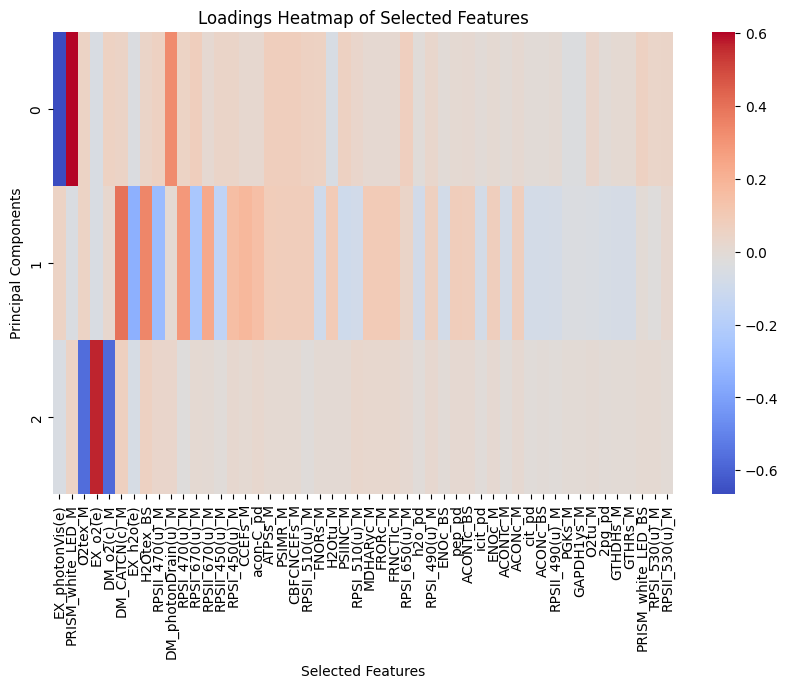

In [10]:

plot_selected_features_heatmap(flux_sampling_pca, merged_df.columns, top_contribs)

STAT NO. 2: Pairwise comparison of flux distributions
This offers a more comprehensive view on which reactions have a different flux distribution in between samples. The test used for this stat is the Kruskal-Wallis ranked test, which is a non-parametric test typically used for flux sampling to compare fluxes between groups


In [8]:
wt_250_750_sig, wt_250_750_non_sig =compare_flux_distributions(wt_250, wt_750, significance_threshold=0.001)
wt_250_1500_sig, wt_250_1500_non_sig =compare_flux_distributions(wt_250, wt_1500, significance_threshold=0.001)
wt_750_1500_sig, wt_750_1500_non_sig =compare_flux_distributions(wt_750, wt_1500, significance_threshold=0.001)


tr_250_750_sig, tr_250_750_non_sig = compare_flux_distributions(tr_250, tr_750, significance_threshold=0.001)
tr_750_1500_sig, tr_750_1500_non_sig = compare_flux_distributions(tr_750, tr_1500, significance_threshold=0.001)
tr_250_1500_sig, tr_250_1500_non_sig = compare_flux_distributions(tr_250, tr_1500, significance_threshold=0.001)

wt_tr_250_sig, wt_tr_250_non_sig = compare_flux_distributions(wt_250, tr_250, significance_threshold=0.001)
wt_tr_750_sig, wt_tr_750_non_sig = compare_flux_distributions(wt_750, tr_750, significance_threshold=0.001)
wt_tr_1500_sig, wt_tr_1500_non_sig = compare_flux_distributions(wt_1500, tr_1500, significance_threshold=0.001)

wt_invariant_fluxes = set(wt_250_750_non_sig) & set(wt_750_1500_non_sig)
#no invariant fluxes between all samples WT

tr_invariant_fluxes = set(tr_250_750_non_sig) & set(tr_750_1500_non_sig)
#0 invariant fluxes

wt_tr_250_750_invariant_fluxes = set(wt_tr_250_non_sig) & set(wt_tr_750_non_sig)
#Only ATGS and CBMKs (Carbamate Kinase) as invariant fluxes detected
#Includes reactions directed towards Star

wt_tr_750_1500_invariant_fluxes = set(wt_tr_750_non_sig) & set(wt_tr_1500_non_sig)
#Only proline PD trannsport detected as invariant @ high conditions


wt_tr_250_1500_invariant_fluxes = set(wt_tr_250_non_sig) & set(wt_tr_1500_non_sig)
#Invariant fluxes are related to photorespiratory export, interestingly enough. CO2 efflux from the Mitochondria, serine import and export from Mit. and Stroma

In [9]:
def find_intersection(lists):
    # Convert the first list to a set
    intersection_set = set(lists[0])

    # Iterate through the remaining lists and take the intersection with the set
    for lst in lists[1:]:
        intersection_set = intersection_set.intersection(lst)

    # Convert the set back to a list and return it
    intersection_list = list(intersection_set)
    return intersection_list


#To Do for z-score plot
- Get a list of all significant reactions found in each treatment comparison
- Generate a dataframe containing z-scores for each reaction per treatment
- Cluster dataframe 

In [10]:
sig_set = find_intersection([wt_tr_250_sig, wt_tr_750_sig, wt_tr_1500_sig])

In [12]:
len(sig_set)

690

In [33]:
#First generate a dataframe with 250, 750, and 1500 PPFD




def h_score_dataframe(wt_list, tr_list, list_sigs):
    
    #First modify the compare_pair() function to output the H statistic instead
    def generate_h_score(reaction, df1, df2):

        sample1 = df1[reaction]
        sample2 = df2[reaction]
        H, pval = kruskal(sample1, sample2)
        return H 
    
    
    #I think I should just compute the log-fold changes per reaction?

    # Create an empty DataFrame with desired column names
    df = pd.DataFrame(columns=["250", "750", "1500"])
    
    results_dict = dict()
    #Generate values for result dictionary
    for rxns in list_sigs:
        _250_kw = generate_h_score(rxns, wt_list[0], tr_list[0])
        _750_kw = generate_h_score(rxns, wt_list[1], tr_list[1])
        _1500_kw = generate_h_score(rxns, wt_list[2], tr_list[2])
    
        results_dict[rxns] = [_250_kw, _750_kw, _1500_kw]
    
    return(results_dict)
        
def cluster_dataframe(df, n_clusters):
    # Calculate ranks for each column
    ranks = df.rank()

    # Perform clustering using K-means algorithm
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(ranks)

    # Add the cluster labels to the DataFrame
    df['Cluster'] = clusters

    return df



In [35]:
results_dict = h_score_dataframe(tr_list, wt_list, sig_set)

In [36]:
results_dict

{'METSs_BS': [14996.85474920865, 15014.25003746066, 15014.25003746066],
 'LCYCRc_BS': [30.331015783856856, 57.64723453705665, 381.51537104566523],
 'RPSII_550(u)_M': [14834.980770252412, 14699.81645078864, 81.33853199520672],
 'DM_ELM(c)_BS': [113.19597853432788, 67.10888586280635, 119.17885960130661],
 'MDHs_BS': [202.65311552397907, 9056.4506353529, 6660.355561863951],
 'DM_APGNNP(c)_BS': [79.30697485205019, 20.03953063332301, 180.7150237485912],
 'ICLx_BS': [153.76577823630942, 167.96625874564052, 1121.0088285541424],
 'HDHs_BS': [14996.85474920865, 15014.25003746066, 15014.25003746066],
 'DM_BUTIN(c)_BS': [181.91364727391192, 39.34914964276686, 445.56546026671276],
 'FNORs_BS': [5774.746857090708, 2015.6041196131555, 5610.228752214083],
 'HPRx_BS': [162.1260634251812, 6132.633403540836, 15.019790944643319],
 'PPHNts_BS': [73.64106263874419, 71.4960605328888, 462.91667872270045],
 'Pitex_M': [692.9426853658078, 2324.777362361616, 14563.000343418491],
 'AOOAs_BS': [14996.85474920865,

STAT NO 3: CORRELATION MATRICES
This code block is used to generate correlation matrices for the purpose of inferring which reactions are directly correlated with each other or not.

Generation of histograms and detailed analysis of Individual reactions at different light levels

Findings for z-score plot

Which reaction groups are least correlated?

In [ ]:
#Flux sampling at low, medium and high light regimens

#Light treatments at 250 PPFD, 750 PPFD and 1500 PPFD

Correlation of flux measurements: use in designing experiments
Uniform random sampling of the steady-state flux space allows for the calculation of the correlation coefficient (rij) between any two fluxes (vi and vj) in the network. Thus, sampling provides a straightforward means of not only calculating perfectly correlated subsets (
), but also of identifying well-correlated, but not perfectly correlated reaction sets. The matrix of squared pairwise correlation coefficients for all the RBC metabolic fluxes was computed. The fluxes can be ordered such that the “correlated reaction sets” (defined here as 
) are listed in order of decreasing number of fluxes in each set (Table 1).


From Price, Schellenberger and Palsson, (2004) -- Uniform Sammpling of flux





Hmm. Interesting results. It shows that fluxes have become more decoupled in the low light regimens compared with medium and high light regimens when comparing results between parametrizations (WT and TR), at a threshold value of 0.001.
